In [1]:
import os
import xarray as xr
import numpy as np
import json
import matplotlib.pyplot as plt
import pyqg
from collections import defaultdict
import glob
from figure_grid import *

%matplotlib inline

In [2]:
#treatment_dir = 'fully_cnn_q_forcing_same_dissipation'
#treatment_dir = 'fully_cnn_q_forcing_diff_dissipation'
treatment_dir = 'fully_cnn_q_forcing_advection'
treatment = xr.concat(
    [xr.open_dataset(f) for f in glob.glob(f"/scratch/zanna/data/pyqg/pyqg_runs/{treatment_dir}/parameterized_pyqg_runs/*.nc")],
    "run").assign_attrs(label="nx=64, parameterized")
treatment

<xarray.Dataset>
Dimensions:     (run: 16, l: 64, k: 33, x: 64, y: 64, time: 44, lev: 2, lev_mid: 1)
Coordinates:
  * x           (x) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y           (y) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * l           (l) float32 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * time        (time) timedelta64[ns] 0 days 00:00:00 ... 1791 days 16:00:00
  * k           (k) float32 0.0 6.283e-06 1.257e-05 ... 0.0001948 0.0002011
  * lev         (lev) int32 1 2
  * lev_mid     (lev_mid) float32 1.5
Dimensions without coordinates: run
Data variables: (12/16)
    entspec     (run, l, k) float32 5.422e-07 4.344e-10 ... 5.293e-34 1.836e-43
    APEflux     (run, l, k) float32 -0.0 -6.362e-07 ... 6.777e-21 1.133e-25
    KEflux      (run, l, k) float32 0.0 8.946e-08 ... 3.097e-19 4.653e-24
    APEgenspec  (run, l, k) float32 0.0 1.722e-06 ... -5.442e-36 -5.605e-45
    q           (run, time, lev, y, x) float32 1.374e-07 4.26e-07 ... 2.34e-07
    u           (run, time, lev, y, x) float32 0.0 0.0 0.0 ... 0.009956 0.008936
    ...          ...
    Qy          (run, time, lev) float32 1.039e-10 -7.222e-12 ... -7.222e-12
    Ensspec     (run, lev, l, k) float32 1.18e-12 6.635e-14 ... 6.446e-44 0.0
    KEspec      (run, lev, l, k) float32 0.0 9.142e-07 ... 1.105e-35 2.803e-45
    EKE         (run, lev) float32 0.002461 5.417e-05 ... 0.002463 5.353e-05
    EKEdiss     (run) float32 5.015e-11 4.83e-11 ... 4.883e-11 4.957e-11
    APEgen      (run) float32 5.289e-11 5.063e-11 ... 5.075e-11 5.406e-11
Attributes: (12/24)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tmax:       155520000.0
    pyqg:twrite:     1000.0
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    label:           nx=64, parameterized

In [14]:
for z in [0,1]:
    with open(f"/scratch/zanna/data/pyqg/pyqg_runs/{treatment_dir}/model_z{z}_mse.txt", 'r') as f:
        print(f"Test MSE, {['upper','lower'][z]} layer: {f.read()}")

Test MSE, upper layer: 8.624454e-24
Test MSE, lower layer: 9.494562e-28


In [3]:
run_idxs = range(16)

controls = [
    xr.concat(
        [xr.open_dataset(f"/scratch/zanna/data/pyqg/pyqg_runs/{n}/control.nc") for n in run_idxs],
        "run").assign_attrs(label='nx=64'),
    xr.concat(
        [xr.open_dataset(f"/scratch/zanna/data/pyqg/pyqg_runs/{n}/lores.nc") for n in run_idxs],
        "run").assign_attrs(label='nx=256, downscaled'),
    xr.concat(
        [xr.open_dataset(f"/scratch/zanna/data/pyqg/pyqg_runs/{n}/hires.nc") for n in run_idxs],
        "run").assign_attrs(label='nx=256')
]

In [4]:
runs = [treatment] + controls

In [5]:
for r in runs:
    r['kinetic_energy'] = 1/2 * (r.ufull**2 + r.vfull**2)
    r['vorticity'] = -r.ufull.differentiate(coord='y') + r.vfull.differentiate(coord='x')

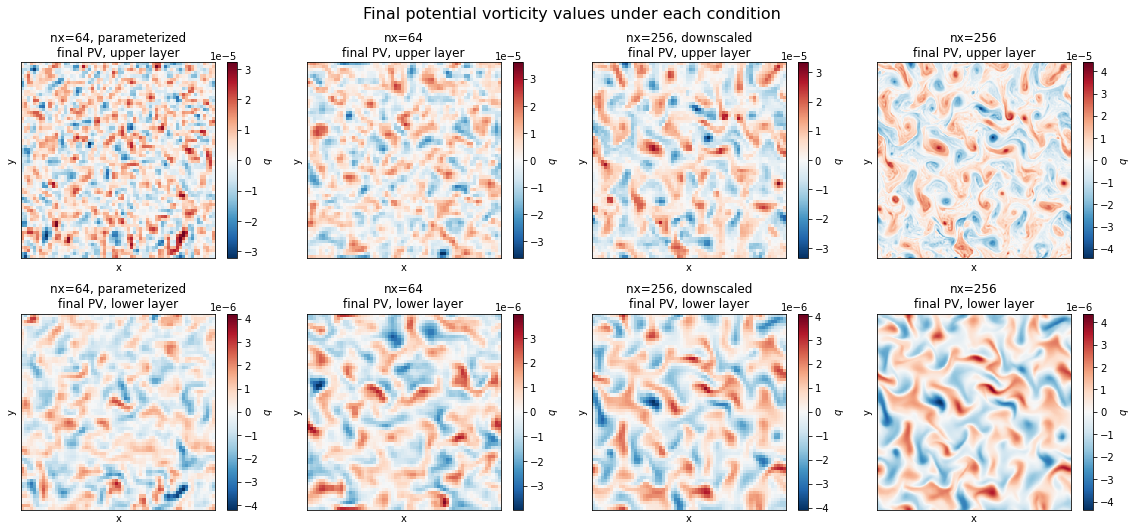

In [6]:
with figure_grid(2, len(runs), rowwidth=len(runs)*4, rowheight=3.75) as g:
    g.title("Final potential vorticity values under each condition", y=0.95)
    for z, layer in zip([0,1], ['upper','lower']):
        for run in runs:
            g.next()
            run.q.isel(time=-1, lev=z, run=-1).plot(cbar_kwargs=dict(label='$q$'))
            plt.title(f"{run.attrs['label']}\nfinal PV, {layer} layer")
            plt.xlabel('x'); plt.xticks([])
            plt.ylabel('y'); plt.yticks([])

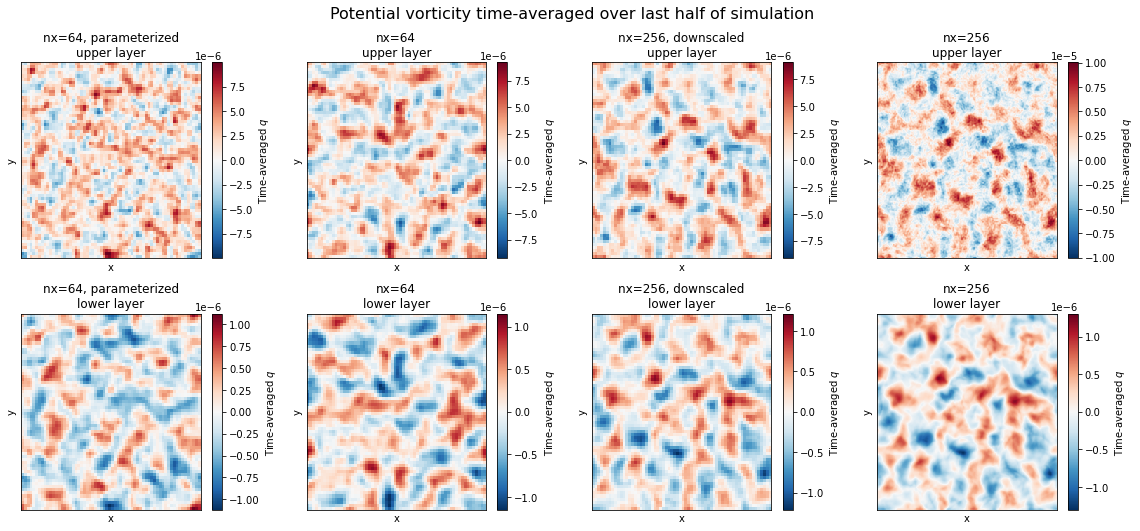

In [7]:
with figure_grid(2, len(runs), rowwidth=len(runs)*4, rowheight=3.75) as g:
    g.title("Potential vorticity time-averaged over last half of simulation", y=0.95)
    for z, layer in zip([0,1], ['upper','lower']):
        for run in runs:
            g.next()
            q_avg = run.q.isel(time=slice(-len(run.coords['time'])//2, None), lev=z, run=-1).mean(dim='time')
            q_avg.plot(cbar_kwargs=dict(label='Time-averaged $q$'))
            plt.title(f"{run.attrs['label']}\n{layer} layer")
            plt.xlabel('x'); plt.xticks([])
            plt.ylabel('y'); plt.yticks([])

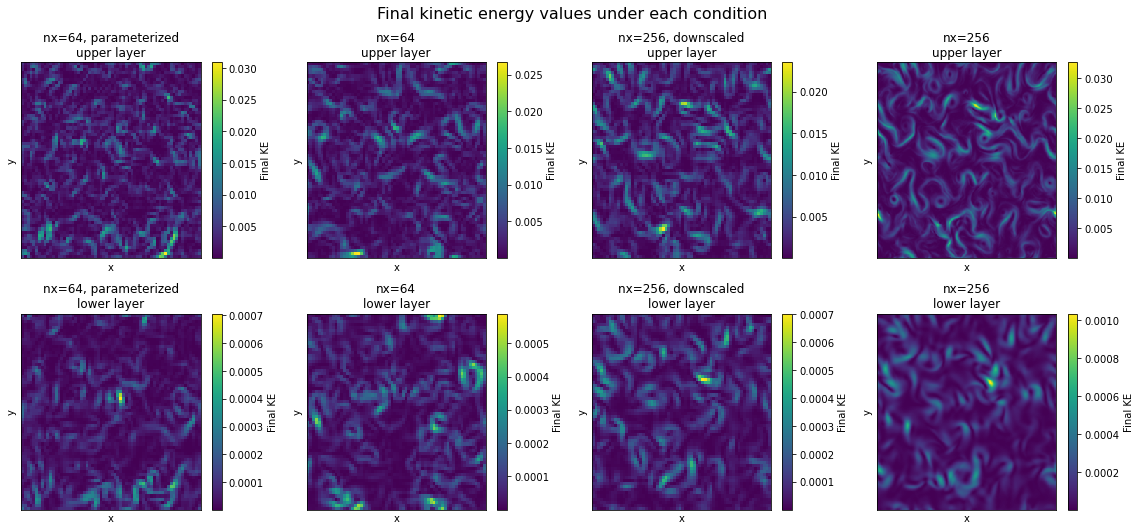

In [8]:
with figure_grid(2, len(runs), rowwidth=len(runs)*4, rowheight=3.75) as g:
    g.title("Final kinetic energy values under each condition", y=0.95)
    for z, layer in zip([0,1], ['upper','lower']):
        for run in runs:
            g.next()
            run.kinetic_energy.isel(time=-1, lev=z, run=-1).plot(cbar_kwargs=dict(label='Final KE'))
            plt.title(f"{run.attrs['label']}\n{layer} layer")
            plt.xlabel('x'); plt.xticks([])
            plt.ylabel('y'); plt.yticks([])

In [9]:
def compare_mvn_kl(q1, q2):
    mean1 = q1.mean(dim='run').data
    mean2 = q2.mean(dim='run').data
    cov1 = q1.var(dim='run').data
    cov2 = q2.var(dim='run').data
    log_det_cov1 = np.log(cov1).sum()
    log_det_cov2 = np.log(cov2).sum() 
    diff = mean1 - mean2
    return 0.5 * (
        (log_det_cov2 - log_det_cov1)
        + ((cov1 + diff**2) / cov2).sum()
        - len(mean1)
    )

def compare_means(q1, q2):
    mean1 = q1.mean(dim='run').data
    mean2 = q2.mean(dim='run').data
    return np.mean((mean1-mean2)**2)

def compare_kolmogorov_smirnoff(q1, q2):
    from scipy.stats import kstest
    return np.mean([kstest(q1[:,t], q2[:,t]).statistic for t in range(q1.shape[1])])

comparisons = {
    'mean_difference': compare_means,
    'mean_ks_statistic': compare_kolmogorov_smirnoff,
    'gaussian_fit_kl': compare_mvn_kl
}

from collections import defaultdict

def last_half(r):
    return r.isel(time=slice(-len(r.coords['time'])//2, None))

def compare_trend(title, fn):
    fig = plt.figure(figsize=(20,3))
    fig.suptitle(title, fontsize=20, y=1.15)

    gs = fig.add_gridspec(1,6)
    ax1 = fig.add_subplot(gs[:3])
    ax1.set_title("Timeseries")
    
    colors = {}
    for r in runs:
        avg = fn(r)
        med = avg.quantile(.5, dim='run')
        lo = avg.quantile(.05, dim='run')
        hi = avg.quantile(.95, dim='run')
        coord = list(med.coords.keys())[0]
        x = med.coords[coord].data.astype(np.float32)
        line = plt.plot(x, med, label=r.attrs['label'])
        colors[r.attrs['label']] = line[0]._color
        plt.fill_between(x, lo, hi, alpha=0.25)
        
    plt.ylabel(med.name)
    plt.xlabel(coord)
    plt.legend()

    if True:
        stats = defaultdict(dict)#lambda: defaultdict(dict))
        for control in controls:
            for comp_key, comp_fn in comparisons.items():
                stats[control.attrs['label']][comp_key] = comp_fn(
                    last_half(fn(treatment)),
                    last_half(fn(control))
                )
                
        bars = []
        control_labels = [control.attrs['label'] for control in controls]
        n_comps = len(comparisons)
        for i, (comp_key, comp_fn) in enumerate(comparisons.items()):
            ax = fig.add_subplot(gs[3+i])
            x = np.arange(len(control_labels))
            y = [stats[c][comp_key] for c in control_labels]
            bars = ax.bar(x, y)
            for j,c in enumerate(control_labels):
                bars[j].set_color(colors[c])
            ax.set_xticks(x)
            ax.set_title(f"{comp_key}\n(last half)")
            ax.set_xticklabels(control_labels, rotation=45, ha='right')
            ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
        
        return stats
    
    plt.tight_layout()

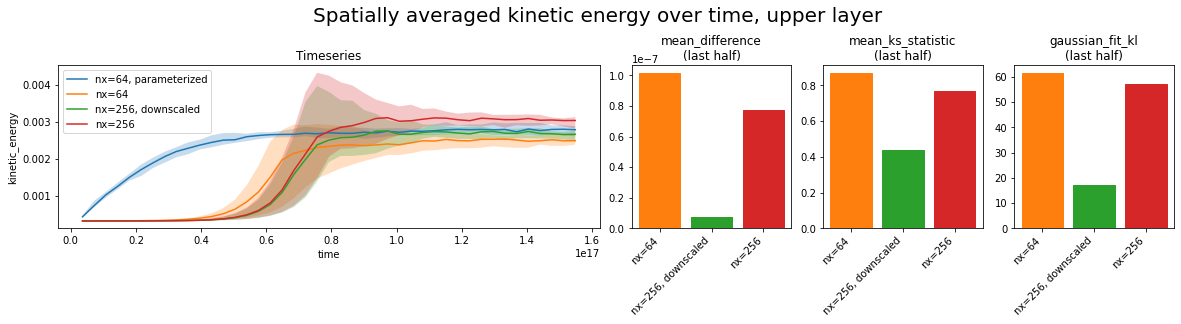

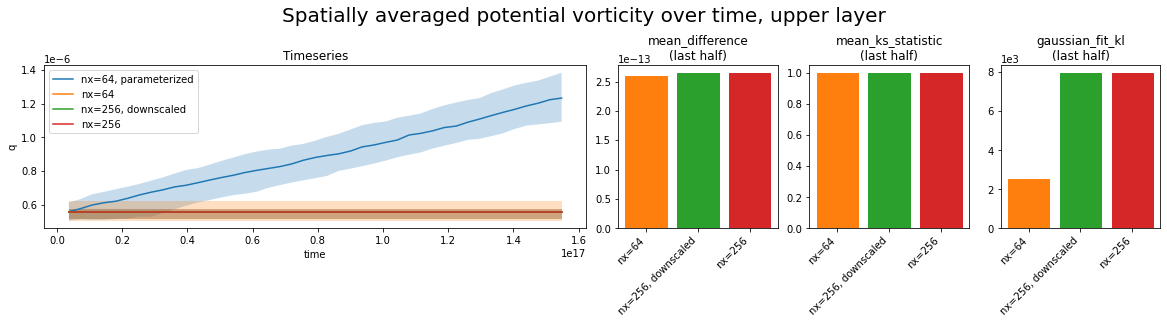

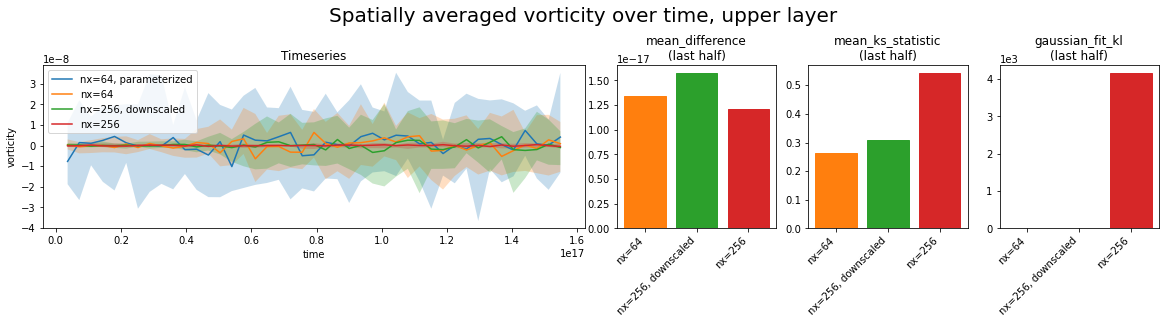

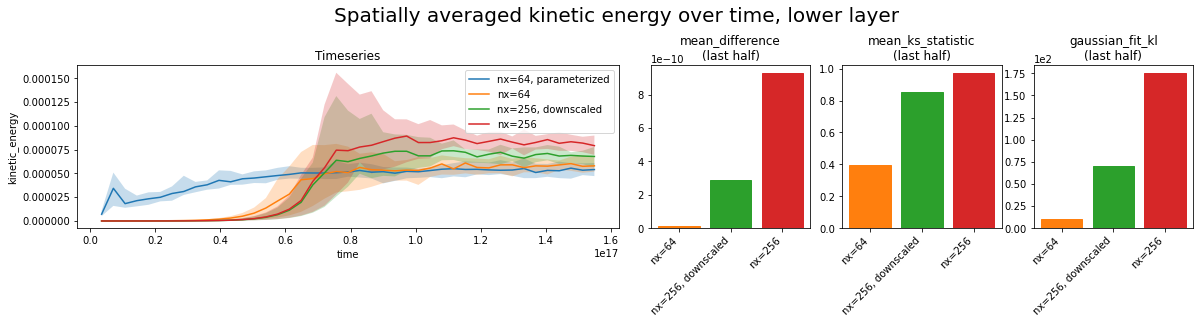

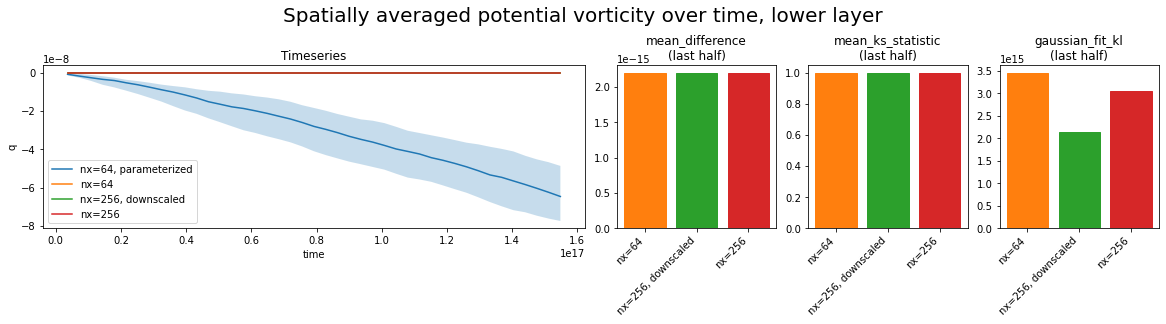

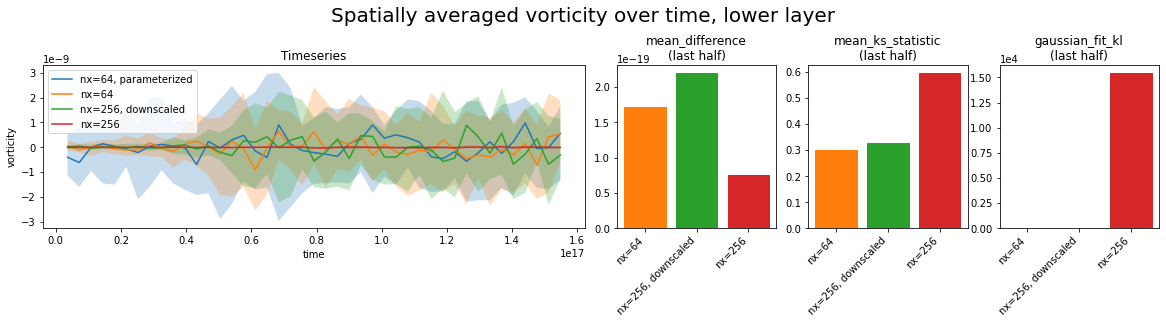

In [10]:
for z, layer in zip([0,1], ['upper','lower']):
    compare_trend(f"Spatially averaged kinetic energy over time, {layer} layer",
            lambda r: r.kinetic_energy.isel(time=slice(1, None), lev=z).mean(dim=('x','y')))

    compare_trend(f"Spatially averaged potential vorticity over time, {layer} layer",
            lambda r: r.q.isel(time=slice(1, None), lev=z).mean(dim=('x','y')))

    compare_trend(f"Spatially averaged vorticity over time, {layer} layer",
            lambda r: r.vorticity.isel(time=slice(1, None), lev=z).mean(dim=('x','y')))

In [11]:
def pyqg_kwargs_for(run):
    import inspect
    sig1 = inspect.signature(pyqg.Model.__init__)
    sig2 = inspect.signature(pyqg.QGModel.__init__)
    return dict([(k.split(':')[1], v) for k,v in run.attrs.items() 
                    if 'pyqg' in k and 'nz' not in k and
                         (k.split(':')[1] in sig1.parameters or k.split(':')[1] in sig2.parameters)])

def pyqg_model_for(run):
    return pyqg.QGModel(log_level=0, **pyqg_kwargs_for(run))


def energy_budget(run):
    from pyqg.diagnostic_tools import calc_ispec
    from collections import OrderedDict

    m = pyqg_model_for(run)
    
    def get_diagnostic(s):
        return run[s].data
    
    KE1spec, KE2spec = get_diagnostic('KEspec')
    k, KE1spec = calc_ispec(m, KE1spec)
    k, KE2spec = calc_ispec(m, KE2spec)
    
    ebud = [get_diagnostic('APEgenspec') / m.M**2,
            get_diagnostic('APEflux')/ m.M**2,
            get_diagnostic('KEflux')/ m.M**2,
            -m.rek * m.del2 * get_diagnostic('KEspec')[1]]
    ebud.append(-np.stack(ebud).sum(axis=0))
    ebud = [calc_ispec(m, term)[1] for term in ebud]
    ebud = np.stack(ebud)
        
    budget = OrderedDict()
    budget['APEgenspec'] = ebud[0]
    budget['APEflux'] = ebud[1]
    budget['KEflux'] = ebud[2]
    budget['KEspec'] = ebud[3]
    budget['Residual'] = ebud[4]
    return k, budget

def plot_energy_budget(run):
    budgets = []
    for i in range(len(run.run)):
        k, budget = energy_budget(run.isel(run=i))
        budgets.append(budget)
    for key,_ in budget.items():
        s = np.array([b[key] for b in budgets])
        plt.semilogx(k, np.mean(s,axis=0), label=key, lw=2)
        plt.fill_between(k, np.percentile(s,5,axis=0), np.percentile(s,95,axis=0), alpha=0.25)
    plt.legend(loc='best', ncol=2)
    plt.xlim(5e-6, 2e-4)
    plt.axhline(0, color='gray', ls='--')
    plt.xlabel("$k$ ($m^{-1}$)")

def power_spectrum(key, run, z=None):
    from pyqg.diagnostic_tools import calc_ispec
    model = pyqg_model_for(run)
    data = run[key].data
    if z is not None:
        data = data[z]
    return calc_ispec(model, data)

def plot_spectra(ax, quantity, z=None, log=True):
    maxes = []
    means = []
    colors = {}
    curves = {}
    for r in runs:
        if r[quantity].min() < 0:
            log = False
    for r in runs:
        if r.attrs['label'] == 'nx=256' and not log:
            continue
        s_vals = []
        for i in range(len(r.run)):
            k,s = power_spectrum(quantity, r.isel(run=i), z=z)
            s_vals.append(s)
        s = np.array(s_vals)
        if log:
            line = ax.loglog(k,s.mean(axis=0),label=r.attrs['label'], lw=3)
        else:
            line = ax.semilogx(k,s.mean(axis=0),label=r.attrs['label'], lw=3)
        ax.fill_between(k, np.percentile(s,5,axis=0), np.percentile(s,95,axis=0), alpha=0.25)
        maxes.append(s.max())
        means.append(s.mean())
        colors[r.attrs['label']] = line[0]._color
        curves[r.attrs['label']] = xr.DataArray(s, (('run',np.arange(s.shape[0])),('k',np.arange(s.shape[1]))))

    if log:
        ax.set_ylim(min(maxes)/100000, max(maxes)*2)
    ax.set_xlim(2e-5, 2e-4)
    ax.set_xlabel("$k$ ($m^{-1}$)")
    ax.set_ylabel(quantity)
    
    if log:
        end_at = min(maxes) / 10
        ax.loglog(k, (k**-3) * end_at / (2e-4**-3), color='gray', label='$k^{-3}$', lw=3, ls='--', alpha=0.5)

    ax.legend(loc='best')
    
    return curves, colors

def compare_spectra(quantity, z=None, **kw):
    fig = plt.figure(figsize=(20,5))
    if z == 0:
        fig.suptitle(f"{quantity} ({runs[0][quantity].attrs['long_name']}, upper layer)", fontsize=20)
    elif z == 1:
        fig.suptitle(f"{quantity} ({runs[0][quantity].attrs['long_name']}, lower layer)", fontsize=20)
    else:
        fig.suptitle(f"{quantity} ({runs[0][quantity].attrs['long_name']})", fontsize=20)

    gs = fig.add_gridspec(1,6)
    ax1 = fig.add_subplot(gs[:3])
    ax1.set_title("Quantity")
    
    curves, colors = plot_spectra(ax1, quantity, z=z, **kw)
    
    if True:
        stats = defaultdict(dict)
        tx = curves[treatment.attrs['label']]
        for control in controls:
            if control.attrs['label'] not in curves:
                continue
            for comp_key, comp_fn in comparisons.items():
                stats[control.attrs['label']][comp_key] = comp_fn(
                    tx,
                    curves[control.attrs['label']].isel(k=slice(0,len(tx.coords['k'])))
                )
                
        bars = []
        control_labels = [control.attrs['label'] for control in controls if control.attrs['label'] in curves]
        n_comps = len(comparisons)
        for i, (comp_key, comp_fn) in enumerate(comparisons.items()):
            ax = fig.add_subplot(gs[3+i])
            x = np.arange(len(control_labels))
            y = [stats[c][comp_key] for c in control_labels]
            bars = ax.bar(x, y)
            for j,c in enumerate(control_labels):
                bars[j].set_color(colors[c])
            ax.set_xticks(x)
            ax.set_title(f"{comp_key}")
            ax.set_xticklabels(control_labels, rotation=45, ha='right')
            ax.ticklabel_format(axis='y', style='sci', scilimits=[-2, 2])
        
        return stats

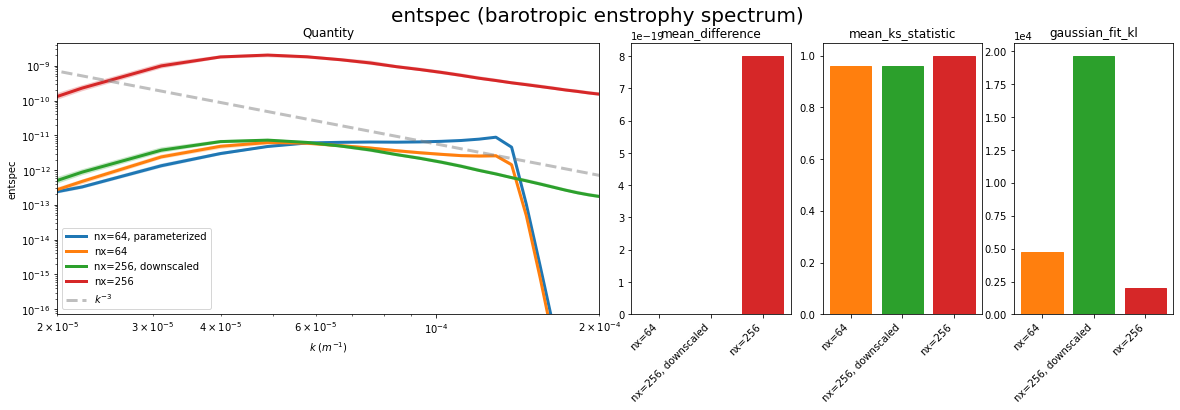

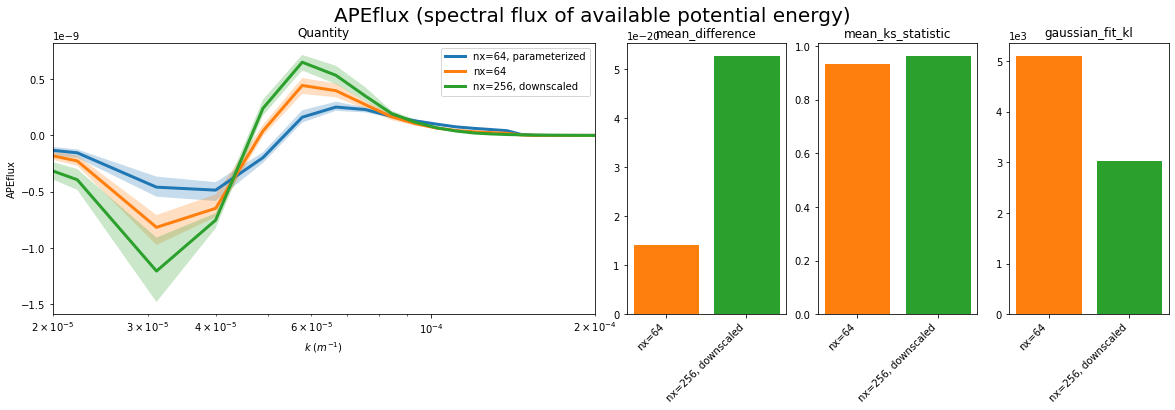

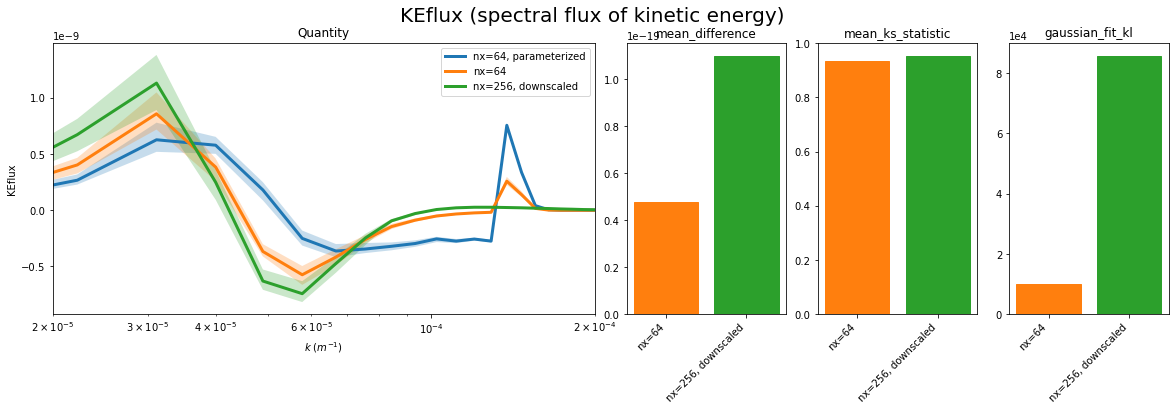

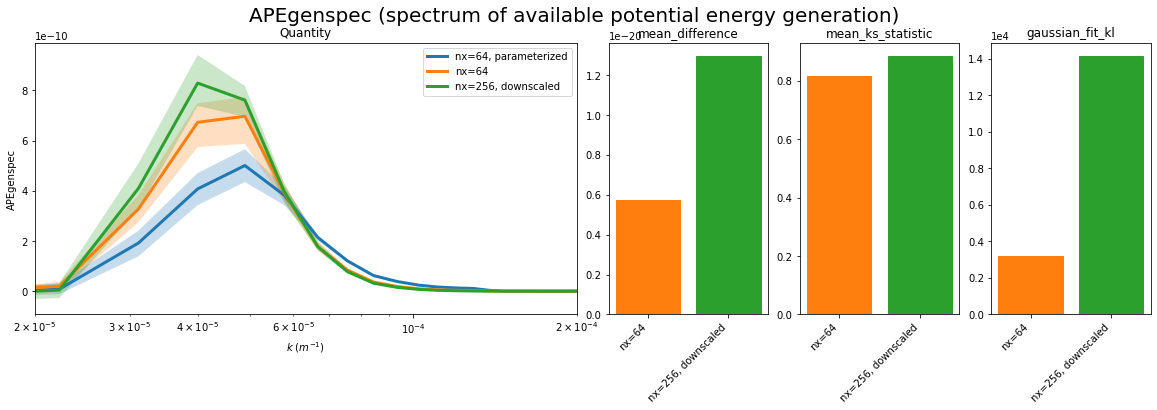

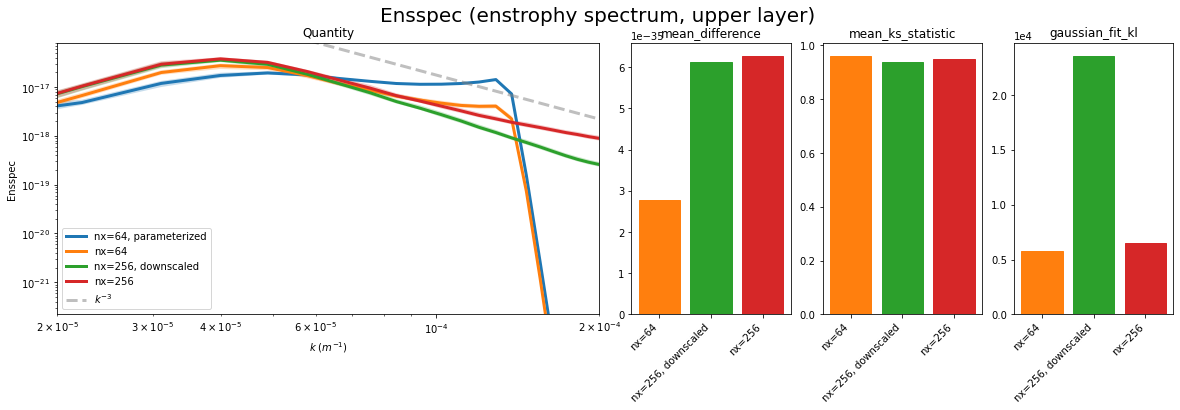

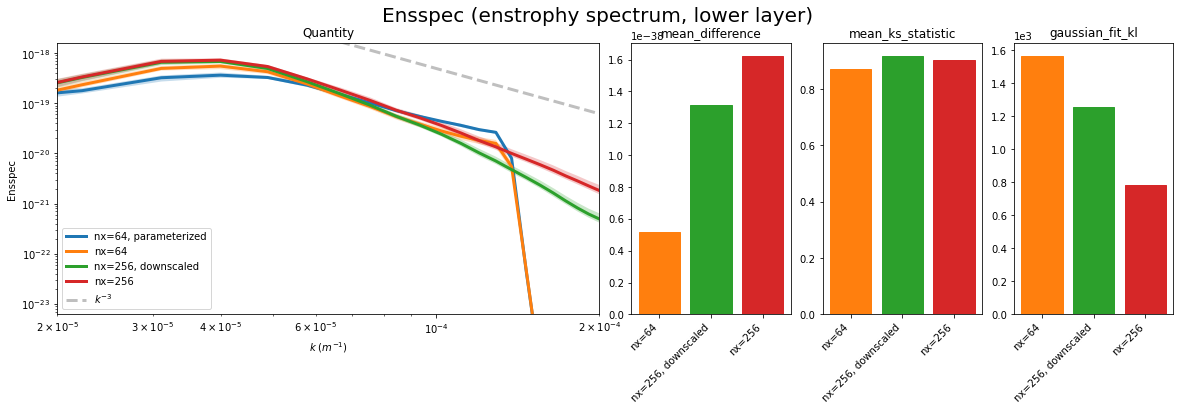

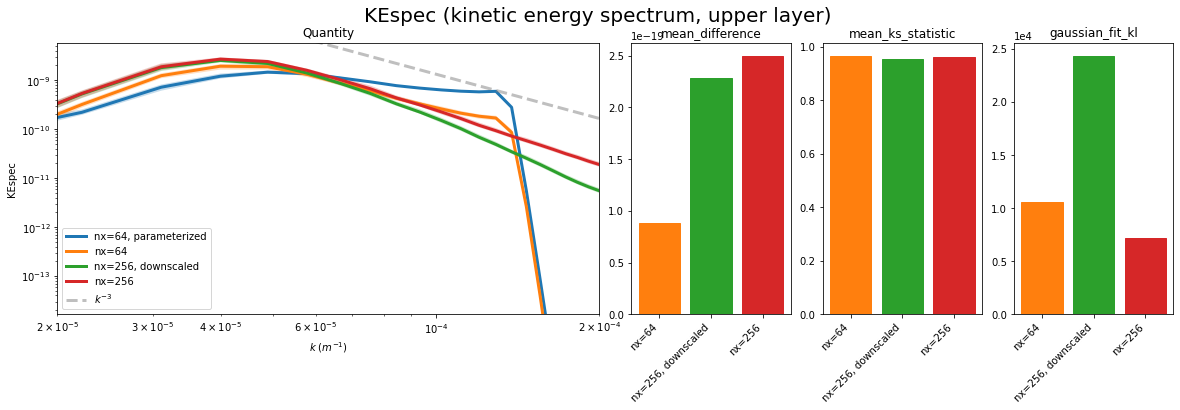

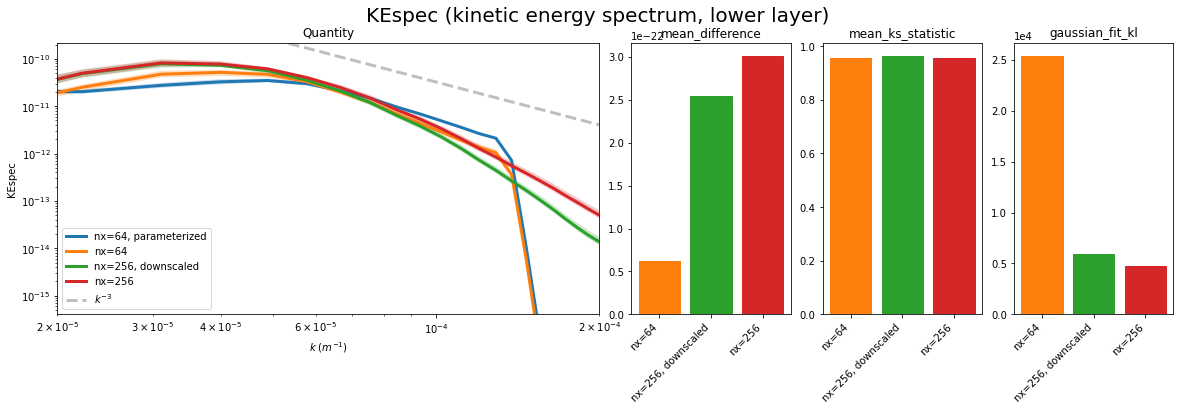

In [12]:
for k,v in runs[0].variables.items():
    if 'l' in v.dims and 'k' in v.dims:
        if 'lev' in v.dims:
            compare_spectra(k, z=0)
            compare_spectra(k, z=1)
        else:
            compare_spectra(k)

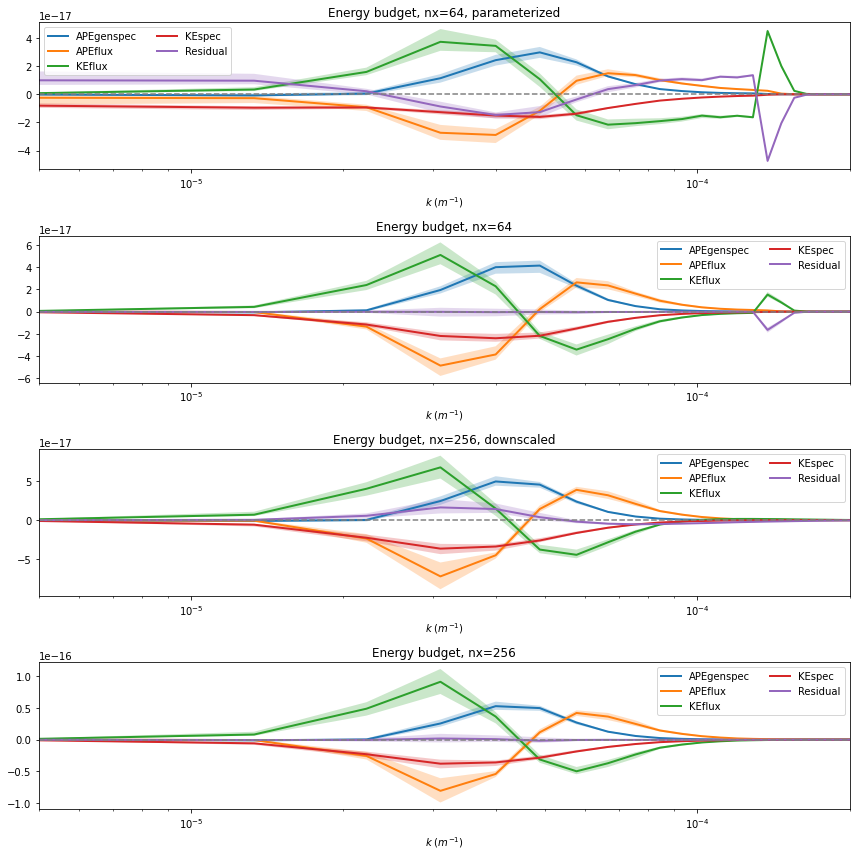

In [13]:
with figure_grid(len(runs),1,rowheight=3) as g:
    for run in runs:
        g.next(title=f"Energy budget, {run.attrs['label']}")
        plot_energy_budget(run)